### Tutorial 01: Using adipocyte U-net to predict adipocyte areas from images.

In this notebook, we'll use ten example images of adipocytes, obtain their segmentation masks from the U-net and calculate some predicted areas.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import keras.backend as K
from keras.metrics import binary_crossentropy
from math import sqrt
from skimage.transform import resize
import logging
import sys
import tensorflow as tf
import sys; #sys.path.append('../')
from src.models.clr_callback import *
from src.models.adipocyte_unet import UNet
from src.utils.runtime import gpu_selection
from src.utils.data import random_transforms
from src.utils.model import dice_coef, jaccard_coef
import cv2
import numpy as np
import cv2
import glob
import random
from matplotlib.image import imsave
import mahotas as mh
from scipy import ndimage
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils.model import dice_coef, jaccard_coef,tru_pos,fls_pos,tru_neg,fls_neg


sns.set_style("whitegrid", {'axes.grid' : False})


In [7]:
def metric_wrapper(yt, yp, metric):
    return K.get_value(metric(K.variable(yt), K.variable(yp)))

**Instantiate the Unet model:**

In [4]:
#model = UNet()
model = UNet('unet')
model.config['data_path'] = '.'
#model.load_data()

**We will be using a GPU. select the appropriate GPU. If you have a single GPU, this will be:**

`visible_devices=0`

In [5]:
gpu_selection(visible_devices="3")
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.Session(config=config)

** Load the trained model weights **

In [73]:
model.compile() 
model.net.load_weights('checkpoints/unet_1024_dilation/weights_loss_val.weights')

** This is the structure of the adipocyte U-net **

In [ ]:
model.net.summary()

** Images need to be standardised to make predictions, we load and normalise the images with the following function: **

```python
process_tiles(img_dir)
```

In [168]:
def process_tiles(img_dir):
    tiles = glob.glob(img_dir +'*')
    samples = []
    for i in tiles:
        s = cv2.imread(i,0)
        s = np.array(s,np.float32) /255
        #_mean, _std = np.mean(s), np.std(s)
        normalised_img = np.expand_dims((s - np.mean(s)) / np.std(s),0)
        #s = normalize(s)
        samples.append(normalised_img)
    samples=np.array(samples)
    return samples

In [169]:
example_imgs = process_tiles('example_tiles/')

(1, 1024, 1024)

** Lets have a look at an example image we would like to segment **

/users/lindgren/craig/.local/lib/python3.4/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


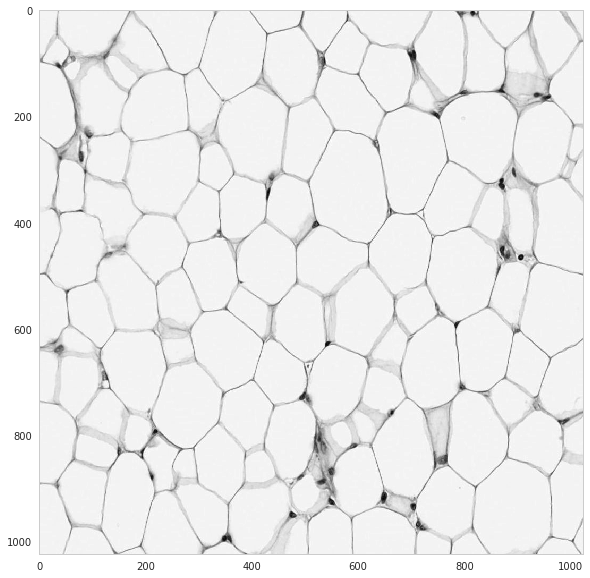

In [173]:
plt.figure(figsize=(10,10))
plt.imshow(example_imgs[2][0,:,:],cmap='gray')
plt.show()

** Here I have defined a small function to loop over images and predict the corresponding segmentation for each image: **
```python
generate_predictions(example_imgs)
```

In [174]:
def generate_predictions(example_imgs):
    preds_bool = []
    preds = []
    for img in example_imgs:
        pred = model.net.predict(img,batch_size=1)
        preds.append(pred)
        img = np.array(pred* 255,dtype='uint8')
        T = mh.thresholding.otsu(img)
        img = img[0,:,:] > T
        preds_bool.append(img)
        
    return preds, preds_bool

In [175]:
preds, preds_bool = generate_predictions(example_imgs)

** Lets plot the corresponding segmentation prediction for the image. Looks good! **

/users/lindgren/craig/.local/lib/python3.4/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


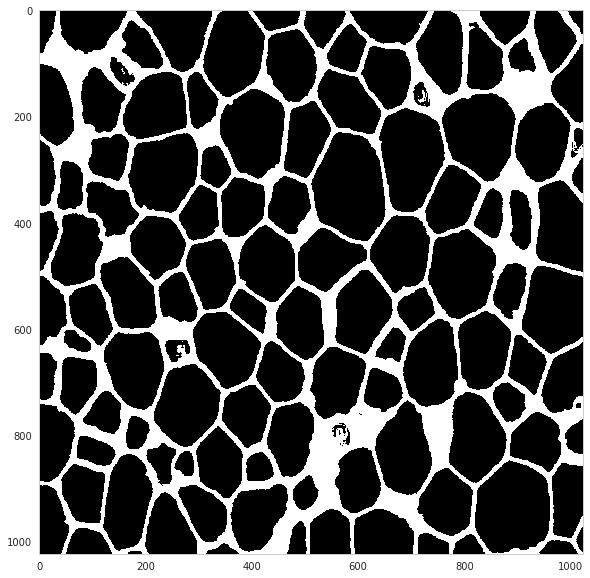

In [176]:
plt.figure(figsize=(10,10))
plt.imshow(preds_bool[2],cmap='gray')
plt.show()

** Lets take the segmentation masks from Adipocyte U-net and calculate the cell areas **

In [218]:
def predict_areas(prd_batch):
    blobs = np.where(prd_batch[0,:,:] > 0.80, 0, 1)
    blobs = np.array(cv2.erode((blobs *1.0).astype(np.float32),np.ones((3,3))),dtype='int8')
    blobs = ndimage.morphology.binary_fill_holes(blobs,structure=np.ones((5,5))).astype(int)
    labels, no_objects = ndimage.label(blobs)
    props = regionprops(labels)
    size={i:props[i].area for i in range (0, no_objects)}
    no_of_cells=(sum(i > 200 and i < 100000 for i in size.values()))
    areas=[i for i in size.values() if i >= 200 and i <= 100000]
    areas=np.array(areas) * 0.495
    return(blobs,areas, np.median(areas),np.mean(areas),no_of_cells)
    




In [219]:
blob_img,areas, median_area, mean_area, no_of_cells = predict_areas(preds[2])

/users/lindgren/craig/.local/lib/python3.4/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


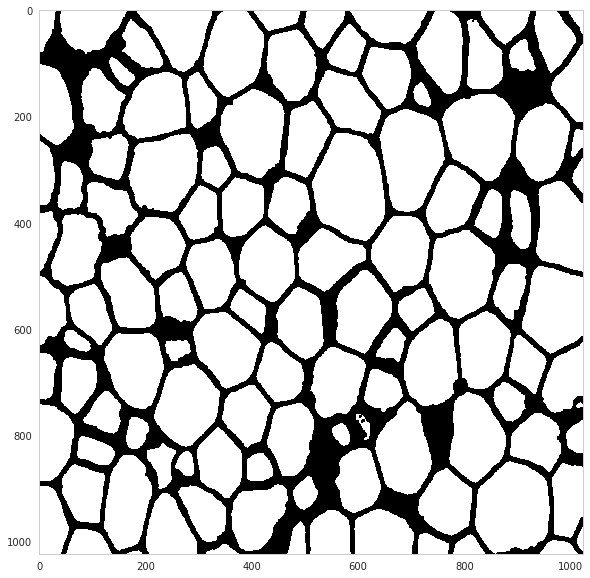

In [220]:
plt.figure(figsize=(10,10))
plt.imshow(blob_img,cmap='gray')
plt.show()

(array([12., 12., 10., 11.,  6.,  8., 11.,  9.,  9.,  5.,  6.,  5.,  3.,
         2.,  3.,  1.,  1.,  0.,  1.,  1.]),
 array([  167.805 ,   675.8235,  1183.842 ,  1691.8605,  2199.879 ,
         2707.8975,  3215.916 ,  3723.9345,  4231.953 ,  4739.9715,
         5247.99  ,  5756.0085,  6264.027 ,  6772.0455,  7280.064 ,
         7788.0825,  8296.101 ,  8804.1195,  9312.138 ,  9820.1565,
        10328.175 ]),
 <a list of 20 Patch objects>)

/users/lindgren/craig/.local/lib/python3.4/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


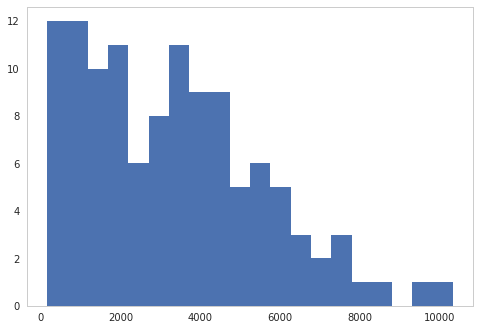

In [222]:
plt.hist(areas, bins=20)